In [13]:
import json

In [14]:
with open('training_data.json') as f:
    data = json.load(f)

n_positions = len(data['Positions'])

In [15]:
import torch

In [35]:
def posToTensor(pos):
    tensor = torch.zeros(1, n_positions)
    tensor[0][pos - 1] = 1
    return tensor

In [72]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_layer_size=None, n_hidden_layers=3):
        super(RNN, self).__init__()

        if hidden_layer_size is None:
            hidden_layer_size = input_size + hidden_size

        self.hidden_size = hidden_size

        self.i2l1 = nn.Linear(input_size + hidden_size, hidden_layer_size)
        self.inner_layers = nn.ModuleList([nn.Linear(hidden_layer_size, hidden_layer_size) for _ in range(n_hidden_layers - 1)])
        self.l2o = nn.Linear(hidden_layer_size, output_size)
        self.l2h = nn.Linear(hidden_layer_size, hidden_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)

        l = self.i2l1(combined)
        for layer in self.inner_layers:
            l = layer(l)
        hidden = self.l2h(l)
        output = self.softmax(self.l2o(l))

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 64
rnn = RNN(n_positions, n_hidden, n_positions)

In [73]:
input = posToTensor(2)
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [36]:
import random
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Outputs a <traj_length x 1 x n_positions> tensor
# giving the observation trajectory of a random example
def randomTrainingExample():
    trajectory = randomChoice(data['traces'])
    obs_trajectory = [state['obs'] for state in trajectory]
    obs_vec_list = [posToTensor(pos) for pos in obs_trajectory]
    return torch.stack(obs_vec_list)

randomTrainingExample()

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,

In [60]:
def fromOneHot(tensor):
    return torch.argmax(tensor, dim=1)

In [74]:

criterion = nn.NLLLoss()
learning_rate = 0.001
def train(example):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    loss = 0
    for i in range(example.size()[0] - 1):
        input = example[i]
        target = example[i + 1]
        output, hidden = rnn(input, hidden)
        loss += criterion(output, fromOneHot(target))

    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / example.size()[0]


In [75]:
train(randomTrainingExample())

(tensor([[-2.9976, -2.9682, -3.0320, -2.9806, -2.8874, -3.1427, -3.0930, -3.0284,
          -3.1772, -2.9679, -2.9913, -3.0066, -2.8912, -2.9898, -2.9274, -2.9789,
          -3.0145, -3.0643, -2.9395, -2.8925]], grad_fn=<LogSoftmaxBackward0>),
 2.764351654052734)

In [76]:
import time
import math
n_iters = 10000
print_every = 500
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
for iter in range(1, n_iters + 1):
    example = randomTrainingExample()
    output, loss = train(example)
    current_loss += loss

        # Print iter number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f' % (iter, iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 0s) 2.7967
1000 10% (0m 1s) 3.0681
1500 15% (0m 2s) 1.7881
2000 20% (0m 2s) 1.1147
2500 25% (0m 3s) 0.8409
3000 30% (0m 4s) 1.0708
3500 35% (0m 4s) 1.1023
4000 40% (0m 5s) 1.6576
4500 45% (0m 6s) 0.8940
5000 50% (0m 7s) 1.0185
5500 55% (0m 7s) 1.7092
6000 60% (0m 8s) 0.7239
6500 65% (0m 9s) 1.8742
7000 70% (0m 9s) 0.9891
7500 75% (0m 10s) 1.6290
8000 80% (0m 11s) 1.7315
8500 85% (0m 12s) 1.4318
9000 90% (0m 12s) 0.9961
9500 95% (0m 13s) 2.1295
10000 100% (0m 14s) 1.1619


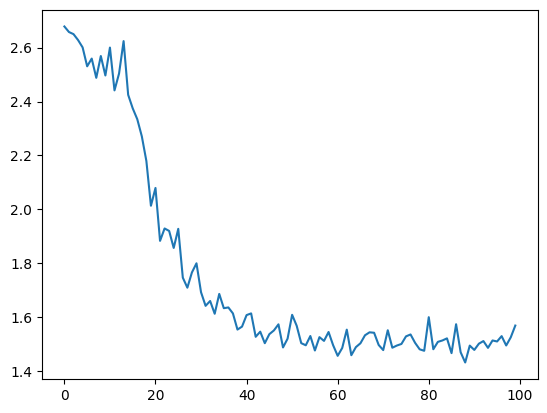

In [77]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)